In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

import warnings
warnings.simplefilter('ignore')

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

[ 3.7820091  2.3164017 -0.1850428] [0.51015484 0.27397949 0.4222054 ] [0.17100239 0.11842528 0.7105723 ]
(1000,)


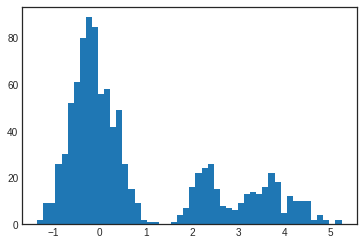

In [74]:
# Generate mixture of 1D Gaussians
dims = 1
n_data = 1000

components = 3
centers_dist = tfp.distributions.Normal(loc=0., scale=3.).sample(components)
stds_dist = tfp.distributions.Uniform(low=0.2, high=0.7).sample(components)
p_dist = tfp.distributions.Dirichlet(concentration=[1./components]*components).sample()

with tf.Session() as sess:
    [centers, stds, p] = sess.run([centers_dist, stds_dist, p_dist])

## I know these give nice results
# components = 3
# centers = [0.1, 1.]
# stds = [0.3, 0.2]
# p1 = 0.4
# p = [p1, 1. - p1]

print(centers, stds, p)

dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution = tfp.distributions.Categorical(probs=p),
    components_distribution = tfp.distributions.Normal(
        loc=centers,
        scale=stds))

with tf.Session() as sess:
    data = sess.run(dist.sample(n_data))
    
print(data.shape)
_ = plt.hist(data, bins=50)

I had many problems with the 
``` python
def model():
    ...
    
log_joint = tfp.edward2.make_log_joint_fn(model)
```
It seems like having the Categorical distribution as input to the log prob function causes errors.
Many `None` gradients encountered.
So, copy from the TFP BGMM [example](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb), without the custom MVN distribution (because I don't understand it). Alternatively, every error that wasn't a None gradient may have been a bad prior, or other problem with HMC.

In [86]:
rv_p = tfp.distributions.Dirichlet(name='p', concentration=[1./components]*components)
rv_mu = tfp.distributions.Normal(name='mu', loc=[0.]*components, scale=[3.]*components)
rv_sigma = tfp.distributions.Uniform(name='sigma', low=[0.]*components, high=[1.]*components)

def joint_log_prob(observations, p, loc, sigma):
    rv_observations = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(probs=p),
        components_distribution=tfp.distributions.Normal(
            loc=loc, scale=sigma))
    log_prob_parts = [
        rv_observations.log_prob(observations),
        rv_p.log_prob(p)[..., tf.newaxis],
        rv_mu.log_prob(loc),
        rv_sigma.log_prob(sigma)
    ]
    sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1))
    return sum_log_prob

In [87]:
posterior_log_prob = lambda *args: joint_log_prob(data, *args)

In [88]:
initial_state = [
    tfp.edward2.Dirichlet(concentration=[1./components]*components),
    tfp.edward2.Normal(loc=[0.]*components, scale=[3.]*components),
    tfp.edward2.Uniform(low=[0.]*components, high=[1.]*components)
]

In [89]:
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=25000,
    num_burnin_steps=7500,
    current_state=initial_state,
    kernel= tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.HamiltonianMonteCarlo(
        posterior_log_prob,
        step_size=0.00001,  ## Adjust if number accepted is very low
        num_leapfrog_steps=10),
    bijector=[
        tfp.bijectors.SoftmaxCentered(),
        tfp.bijectors.Identity(),    
        tfp.bijectors.Identity(),    
    ]))

[p_post, locs_post, scales_post] = states
accepted = kernel_results.inner_results.is_accepted

In [90]:
with tf.Session() as sess:
    [ p_post_, locs_post_, scales_post_, accepted_] = sess.run([
        p_post, locs_post, scales_post, accepted])
    
print('accepted:', accepted_.sum())
print('p:', np.mean(p_post_, axis=0))
print('loc:', np.mean(locs_post_, axis=0))
print('scale:', np.mean(scales_post_, axis=0))

accepted: 23673
p: [0.02427132 0.80268216 0.17296545]
loc: [ 2.1482491  1.2306561 -2.0794437]
scale: [0.6568462  0.9944436  0.21424423]


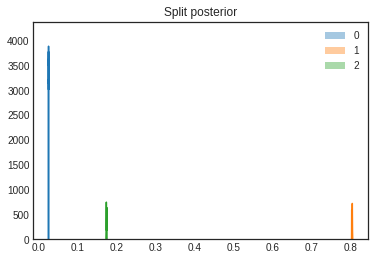

In [95]:
for k in range(components):
    sns.distplot(p_post_[:,k], label='{}'.format(k))
plt.title('Split posterior')
plt.legend()

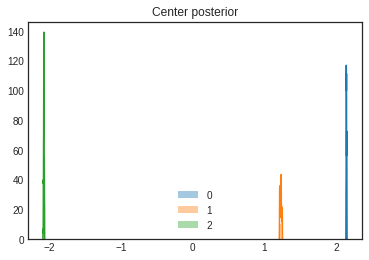

In [96]:
for k in range(components):
    sns.distplot(locs_post_[:,k], label='{}'.format(k))
plt.title('Center posterior')
plt.legend()

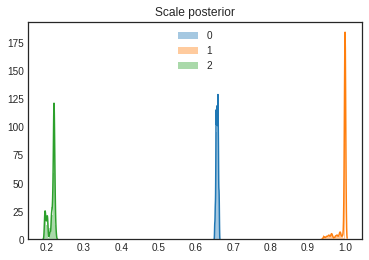

In [97]:
for k in range(components):
    sns.distplot(scales_post_[:, k], label='{}'.format(k))
plt.title('Scale posterior')
plt.legend()

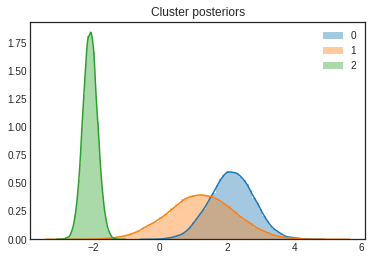

In [98]:
pcs = [tfp.distributions.Normal(loc=locs_post_[:,k], scale=scales_post_[:,k]).sample() for k in range(components)]

with tf.Session() as sess:
    pcs_ = sess.run(pcs)
    
for k, pcs_k in enumerate(pcs_):
    sns.distplot(pcs_k, label='{}'.format(k))
plt.title('Cluster posteriors')
plt.legend()